## Project: Knowledge Based Recommendation System
### Unsupervised Modeling

#### DSC 630

Taniya Adhikari 15/24/2021

In [1]:
from bs4 import BeautifulSoup as BS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings; warnings.simplefilter('ignore')

import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import textblob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
productList_df = pd.read_csv("prod_descR.csv", index_col=0)
productList_df.head(3)

,product_id,product_name,product_brand,price,product_type,product_description,description_clean
0,6562638659653,VITALIFT-A,Dr. Different,42.0,Other/Spot Treatments,this nighttime skin treatment is ideal for tho...,nighttime skin treatment ideal look improve ap...
1,6562639675461,VITALIFT-A Forte,Dr. Different,52.0,Other/Spot Treatments,those that need an extra boost to smooth out f...,need extra boost smooth fine line wrinkle real...
2,6562640429125,VITALIFT-A Eye & Neck,Dr. Different,40.0,Eye Treatment,for those looking to target fine lines and wri...,look target fine line wrinkle specifically aro...


In [3]:
reviews_df = pd.read_csv("reviews_preprocess.csv", index_col=0)
reviews_df.head(3)

,product_id,review_sentiment,review_similarity,pos_tags,wordnet_pos,lemmatized,aaa,aaaaand,aaaah,aaahhh,...,ziploc,zit,zitkilla,zits,zitsacne,zitspimples,zitsticka,zoe,zone,zoom
0,4669755719749,this makes my skin smooth and soft and is ligh...,make skin smooth soft lightweight absorbs quickly,"[('makes', 'VBZ'), ('skin', 'JJ'), ('smooth', ...","[('makes', 'v'), ('skin', 'a'), ('smooth', 'a'...","['make', 'skin', 'smooth', 'soft', 'lightweigh...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4669755719749,love the silky texture its very lightweight bu...,love silky texture lightweight hydrate leaf sk...,"[('love', 'VB'), ('silky', 'JJ'), ('texture', ...","[('love', 'v'), ('silky', 'a'), ('texture', 'n...","['love', 'silky', 'texture', 'lightweight', 'h...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4669755719749,i ve been trying to find a moisturizer that wo...,try find moisturizer would dry skin month espe...,"[('trying', 'VBG'), ('find', 'NN'), ('moisturi...","[('trying', 'v'), ('find', 'n'), ('moisturizer...","['try', 'find', 'moisturizer', 'would', 'dry',...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Sentiment Analysis

In [4]:
import nltk
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
sid = SentimentIntensityAnalyzer()
reviews_df['scores'] = reviews_df['review_sentiment'].apply(lambda review: sid.polarity_scores(review))

reviews_df['compound']  = reviews_df['scores'].apply(lambda score_dict: score_dict['compound'])
reviews_df['compound'].head()

0    0.0000
1    0.8945
2    0.6597
3    0.9531
4    0.4215
Name: compound, dtype: float64

In [6]:
df = pd.merge(reviews_df, productList_df, how="inner", on=["product_id"])

#### Cosine Similarity

In [7]:
def results(list1, user_input, price, df):
    from scipy import spatial

# price filters data for the price range and list1 filters for product type
    price = float(price)
    if price > 2.5:
        df = df[df.price_y<= price]
        rslt_df = df.loc[df['product_type'].isin(list1)]
    else:
        print("No product in that price range")

    new = []
    for index, row in rslt_df.iterrows():
        review_vector = []
        feature_vector = [] #this vector represents the preferred features specified by a user such as skin concerns and skin goals
        for item in user_input:
            feature_vector.append(1)
            if row[item] == 1:
                review_vector.append(1)
            elif row[item] == 0:
                review_vector.append(0)
            else:
                review_vector.append(0)

        cosine_similarity = 1 - spatial.distance.cosine(feature_vector, review_vector) #calculates the cosine similarity between the two vectors
        if cosine_similarity >=.5:
            new.append([row['product_name'], row['price_y'], cosine_similarity, row['compound']])
        else:
            None

    df1 = pd.DataFrame(new, columns=["product_name", "price", "similarity_score", "sentiment_score"])
    score_df = df1.groupby("product_name").mean()
    score_df.reset_index(inplace=True)
    score_df["weighted_score"] = (0.6*score_df["similarity_score"])+(.4*score_df["sentiment_score"])
    score_df.head() 
    
    plot_df = score_df.nlargest(3, 'weighted_score')
    x = plot_df.drop(columns=['similarity_score', 'sentiment_score', 'weighted_score'])
    print(x)
    plots(plot_df)


### Plotting

In [8]:
def plots(plot_df):
    # set figure size
    plt.rcParams['figure.figsize'] = (5,2)
    sns.color_palette("rocket_r", as_cmap=True)
    sns.barplot(x =plot_df['sentiment_score'],  y= plot_df['product_name'], data = plot_df, palette=("rocket_r"))

    plt.xlabel("Sentiment Score of Product")
    plt.ylabel("Product Name")
    plt.title("Sentiment Score of Product based on Reviews")
    plt.show()

    # set figure size
    plt.rcParams['figure.figsize'] = (5,2)
    sns.color_palette("rocket_r", as_cmap=True)
    sns.barplot(x =plot_df['similarity_score'],  y= plot_df['product_name'], data = plot_df, palette=("rocket_r"))

    plt.xlabel("Similarity Score of Product")
    plt.ylabel("Product Name")
    plt.title("Similarity Score of Product based on User Preference Features")
    plt.show()


    # set figure size
    plt.rcParams['figure.figsize'] = (5,2)
    sns.color_palette("rocket_r", as_cmap=True)
    sns.barplot(x =plot_df['weighted_score'],  y= plot_df['product_name'], data = plot_df, palette=("rocket_r"))

    plt.xlabel("Weighted Score of Product")
    plt.ylabel("Product Name")
    plt.title("Weighted Score of Product based on User Preference Features")
    # Show the plot
    plt.show()

#### User Application

In [9]:
#### User Preferences Application
!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets

Skin_Concern = ["acne", "aging", "dehydration","clogged pore", "hyper pigmentation", "sensitive", "redness", "uneven skintone", "dryness"]
Product_Type = ["Cleanser", "Mask", "Toner", "Moisturizer","Serum","Other/Spot Treatments","Essence",
                "Sheet Mask","Eye Treatment","Sun Protection","Exfoliator","Lip Treatment"]
Skin_Type = ["oily", "dry", "combination", "normal"]
Price_Range = ["$0-$20", "$21-$40", "$41-$60", "$61-$80"]
Skin_Goals = ["unclog pore", "minimize pore", "reduce wrinkles", "remove blackheads", "remove dark spots", 
              "improve skin texture","reduce pigmentation", "soft skin", "hydration", "detox", "smooth skin", 
              "skin brighten","skin glow", "improve complexion", 'clear skin']


def user_inputs(list1, list2, list3, list4, df):
    print("Select Product Type: Check All that Apply")
    checkboxes1 = [widgets.Checkbox(value=False, description=label) for label in Product_Type]
    output1 = widgets.VBox(children=checkboxes1)
    display(output1)

    print("Select Skin Type")
    checkboxes2 = [widgets.Checkbox(value=False, description=label) for label in Skin_Type]
    output2 = widgets.VBox(children=checkboxes2)
    display(output2)

    print("What are your Concerns? Check All that Apply")
    checkboxes3 = [widgets.Checkbox(value=False, description=label) for label in Skin_Concern]
    output3 = widgets.VBox(children=checkboxes3)
    display(output3)

    print("What are your Skin Goals? Check All that Apply")
    checkboxes4 = [widgets.Checkbox(value=False, description=label) for label in Skin_Goals]
    output4 = widgets.VBox(children=checkboxes4)
    display(output4)

    print("Select your price range")
    slider = widgets.FloatSlider(value=60,min=2.5,max=60.0,step=0.1,description='Price Range:',
                                 disabled=False,continuous_update=False,orientation='horizontal',
                                 readout=True,readout_format='.1f')
    text = widgets.IntText()
    display(slider, text)
    widgets.jslink((slider, 'value'), (text, 'value'))
    
    checkboxes = checkboxes2 + checkboxes3 + checkboxes4
    btn = widgets.Button(description='Submit')
    display(btn)
    
    data=df
    
    def btn_eventhandler(obj):
        data1 = []
        for i in range(0, len(checkboxes1)):
            if checkboxes1[i].value == True:
                X = checkboxes1[i].description
                data1.append(X)
        print("Product Type: {}".format(data1))
        
        data2 = []
        for i in range(0, len(checkboxes)):
            if checkboxes[i].value == True:
                X = checkboxes[i].description
                X = X.split()
                data2 = data2 + X 
        print("User Preferences: {}".format(data2))
        x = slider.value
        print("Price Range: ${}".format(x))
        results(data1, data2, x, df)
        
    btn.on_click(btn_eventhandler)
    

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Select Product Type: Check All that Apply


Select Skin Type


What are your Concerns? Check All that Apply


What are your Skin Goals? Check All that Apply


Select your price range


FloatSlider(value=60.0, continuous_update=False, description='Price Range:', max=60.0, min=2.5, readout_format…

IntText(value=0)

Button(description='Submit', style=ButtonStyle())

Product Type: ['Cleanser', 'Mask']
User Preferences: ['oily', 'aging', 'clogged', 'pore', 'hyper', 'pigmentation', 'unclog', 'pore', 'minimize', 'pore', 'reduce', 'wrinkles', 'hydration', 'smooth', 'skin']
Price Range: $46.0
                                      product_name  price
1                   A-Clear Soothing Foam Cleanser  20.00
15                          Real Mugwort Clay Mask  24.00
9   Intensive Pore Clean Cleansing Foam (Charcoal)   8.99


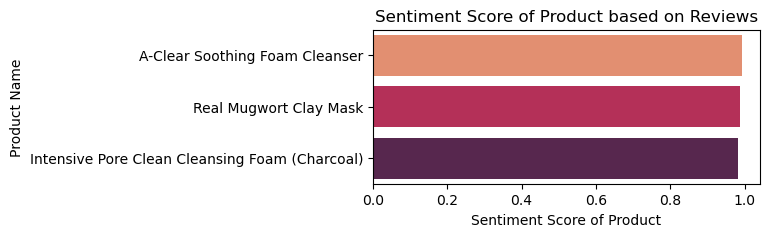

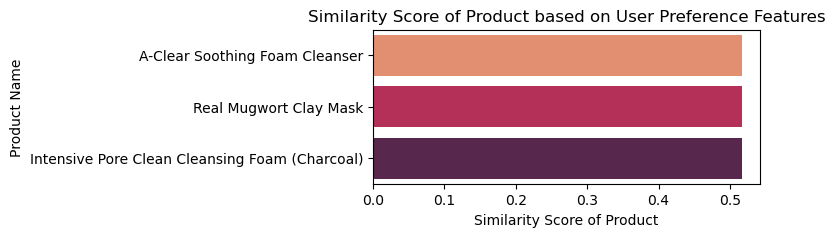

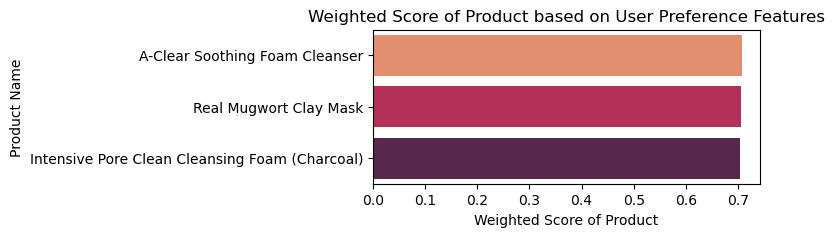

Product Type: ['Toner', 'Moisturizer']
User Preferences: ['oily', 'aging', 'dehydration', 'hyper', 'pigmentation', 'reduce', 'wrinkles', 'remove', 'blackheads', 'remove', 'dark', 'spots', 'improve', 'skin', 'texture', 'hydration', 'smooth', 'skin']
Price Range: $46.0
               product_name  price
3   Probiotics Relief Cream   34.0
2  Dual Moist Toning Lotion   22.0
0       Calming Clean Water   20.0


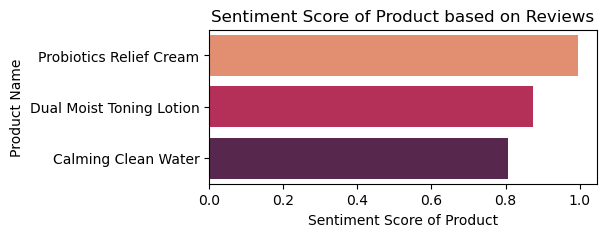

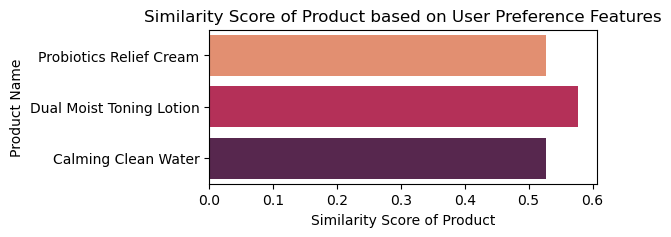

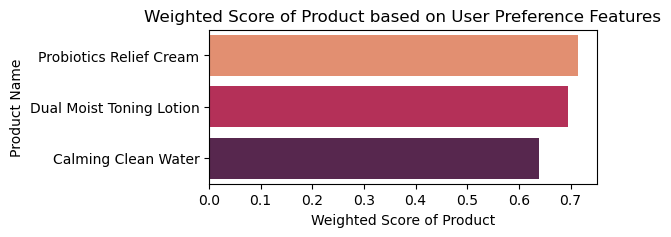

In [13]:
user_inputs(Product_Type, Skin_Type, Skin_Concern, Skin_Goals, df)